In [1]:
import os 
os.getcwd()

import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.special import rel_entr

from engine_hms_model import (
    KagglePaths, LocalPaths, ModelConfig
)

pd.set_option('display.max_columns', None)

PATHS = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", PATHS.OUTPUT_DIR)

Output Dir:  ./outputs/


In [2]:
train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:]

print("targets: ", targets.to_list())

train_csv['total_votes'] = train_csv[targets].sum(axis=1)

targets_prob = [f"{t.split('_')[0]}_prob" for t in targets]
train_csv[targets_prob] = train_csv[targets].div(train_csv['total_votes'], axis=0)

train_csv['entropy'] = train_csv[targets_prob].apply(lambda row: sum(rel_entr([1/6]*6, row.values+1e-5)), axis=1)

train_csv['is_hard'] = (train_csv['entropy'] < 5.5).astype(int)

targets:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


In [22]:
tgt_list = targets.to_list()

# agg_dict = {
#         'spectrogram_id': 'first',
#         'spectrogram_label_offset_seconds': ['min', 'max'],
#         'patient_id': 'first',
#         'expert_consensus': 'first',
#         'is_hard': lambda x: x.sum() / x.count()
#     }

agg_dict = {
    'spectrogram_id': 'first',
    'spectrogram_label_offset_seconds': ['min', 'max'],
    'patient_id': 'first',
    'expert_consensus': ['first', 'count', 'nunique'],
    'entropy': 'mean',
    'is_hard': lambda x: x.sum() / x.count()
}

for tgt in tgt_list:
    agg_dict[tgt] = 'sum'
    
df_agg = train_csv.groupby(['eeg_id']).agg(agg_dict).reset_index()
df_agg.columns = ['eeg_id','spectrogram_id', 'min', 'max', 'patient_id', 'target', 'target_count', 'target_nunique','averge_entropy', 'is_hard_ratio'] + tgt_list

df_agg['total_votes'] = df_agg[tgt_list].sum(axis=1)
df_agg[tgt_list] = df_agg[tgt_list].apply(lambda x: x / x.sum(), axis=1)

In [30]:
train_csv[train_csv['eeg_id']==4282888597]#[['eeg_id', 'spectrogram_id', 'spectrogram_label_offset_seconds', 'expert_consensus', 'is_hard', 'entropy', 'total_votes'] + tgt_list ]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,entropy,is_hard
77532,4282888597,0,0.0,1564580568,0,0.0,2273880622,45464,LRDA,3,0,0,8,0,0,11,0.272727,0.0,0.0,0.727273,0.0,0.0,6.153139,0
77533,4282888597,1,4.0,1564580568,1,4.0,2487573657,45464,LRDA,3,0,0,8,0,0,11,0.272727,0.0,0.0,0.727273,0.0,0.0,6.153139,0
77534,4282888597,2,6.0,1564580568,2,6.0,3828201436,45464,LRDA,3,0,0,8,0,0,11,0.272727,0.0,0.0,0.727273,0.0,0.0,6.153139,0
77535,4282888597,3,8.0,1564580568,3,8.0,3179903523,45464,LRDA,3,0,0,8,0,0,11,0.272727,0.0,0.0,0.727273,0.0,0.0,6.153139,0
77536,4282888597,4,10.0,1564580568,4,10.0,4153145862,45464,LRDA,3,0,0,8,0,0,11,0.272727,0.0,0.0,0.727273,0.0,0.0,6.153139,0
77537,4282888597,5,12.0,1564580568,5,12.0,2439940708,45464,LRDA,3,0,0,8,0,0,11,0.272727,0.0,0.0,0.727273,0.0,0.0,6.153139,0
77538,4282888597,6,16.0,1564580568,6,16.0,3184552128,45464,LRDA,3,0,0,8,0,0,11,0.272727,0.0,0.0,0.727273,0.0,0.0,6.153139,0
77539,4282888597,7,18.0,1564580568,7,18.0,910495525,45464,LRDA,3,0,0,8,0,0,11,0.272727,0.0,0.0,0.727273,0.0,0.0,6.153139,0
77540,4282888597,8,20.0,1564580568,8,20.0,3476771950,45464,LRDA,3,0,0,8,0,0,11,0.272727,0.0,0.0,0.727273,0.0,0.0,6.153139,0
77541,4282888597,9,22.0,1564580568,9,22.0,608227857,45464,LRDA,3,0,0,8,0,0,11,0.272727,0.0,0.0,0.727273,0.0,0.0,6.153139,0


In [35]:
eeg_seq = pd.read_parquet("./inputs/hms-harmful-brain-activity-classification/train_eegs/4282888597.parquet")
start = (0 + 40) // 2
series_1 = eeg_seq.iloc[start*200:start*200+50*200, :].values 
start = (42 + 106) // 2
series_2 = eeg_seq.iloc[start*200:start*200+50*200, :].values

In [54]:
tmp = {
    'A': [1, np.nan, 3, 4],
    'B': [np.nan, np.nan, np.nan, np.nan],
    'C': [1, 2, np.nan, 4]
}

tmp_df = pd.DataFrame(tmp)

# Fill NaN values with the mean of each column, then fill all-NaN columns with zeros
tmp_df = tmp_df.fillna(tmp_df.mean()).fillna(0)

tmp_df


,A,B,C
0,1.000000,0.0,1.000000
1,2.666667,0.0,2.000000
2,3.000000,0.0,2.333333
3,4.000000,0.0,4.000000


In [50]:
tmp.mean()

A    2.75
B    3.75
dtype: float64

In [40]:
EEG_FEAT_USE =  ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
EEF_FEAT_INDEX = {x:y for x,y in zip(EEG_FEAT_USE, range(len(EEG_FEAT_USE)))}
EEF_FEAT_INDEX

{'Fp1': 0, 'T3': 1, 'C3': 2, 'O1': 3, 'Fp2': 4, 'C4': 5, 'T4': 6, 'O2': 7}

In [43]:
x1 = series_1[:,EEF_FEAT_INDEX['Fp1']] - series_1[:,EEF_FEAT_INDEX['T3']]
x2 = series_2[:,EEF_FEAT_INDEX['Fp1']] - series_2[:,EEF_FEAT_INDEX['T3']]

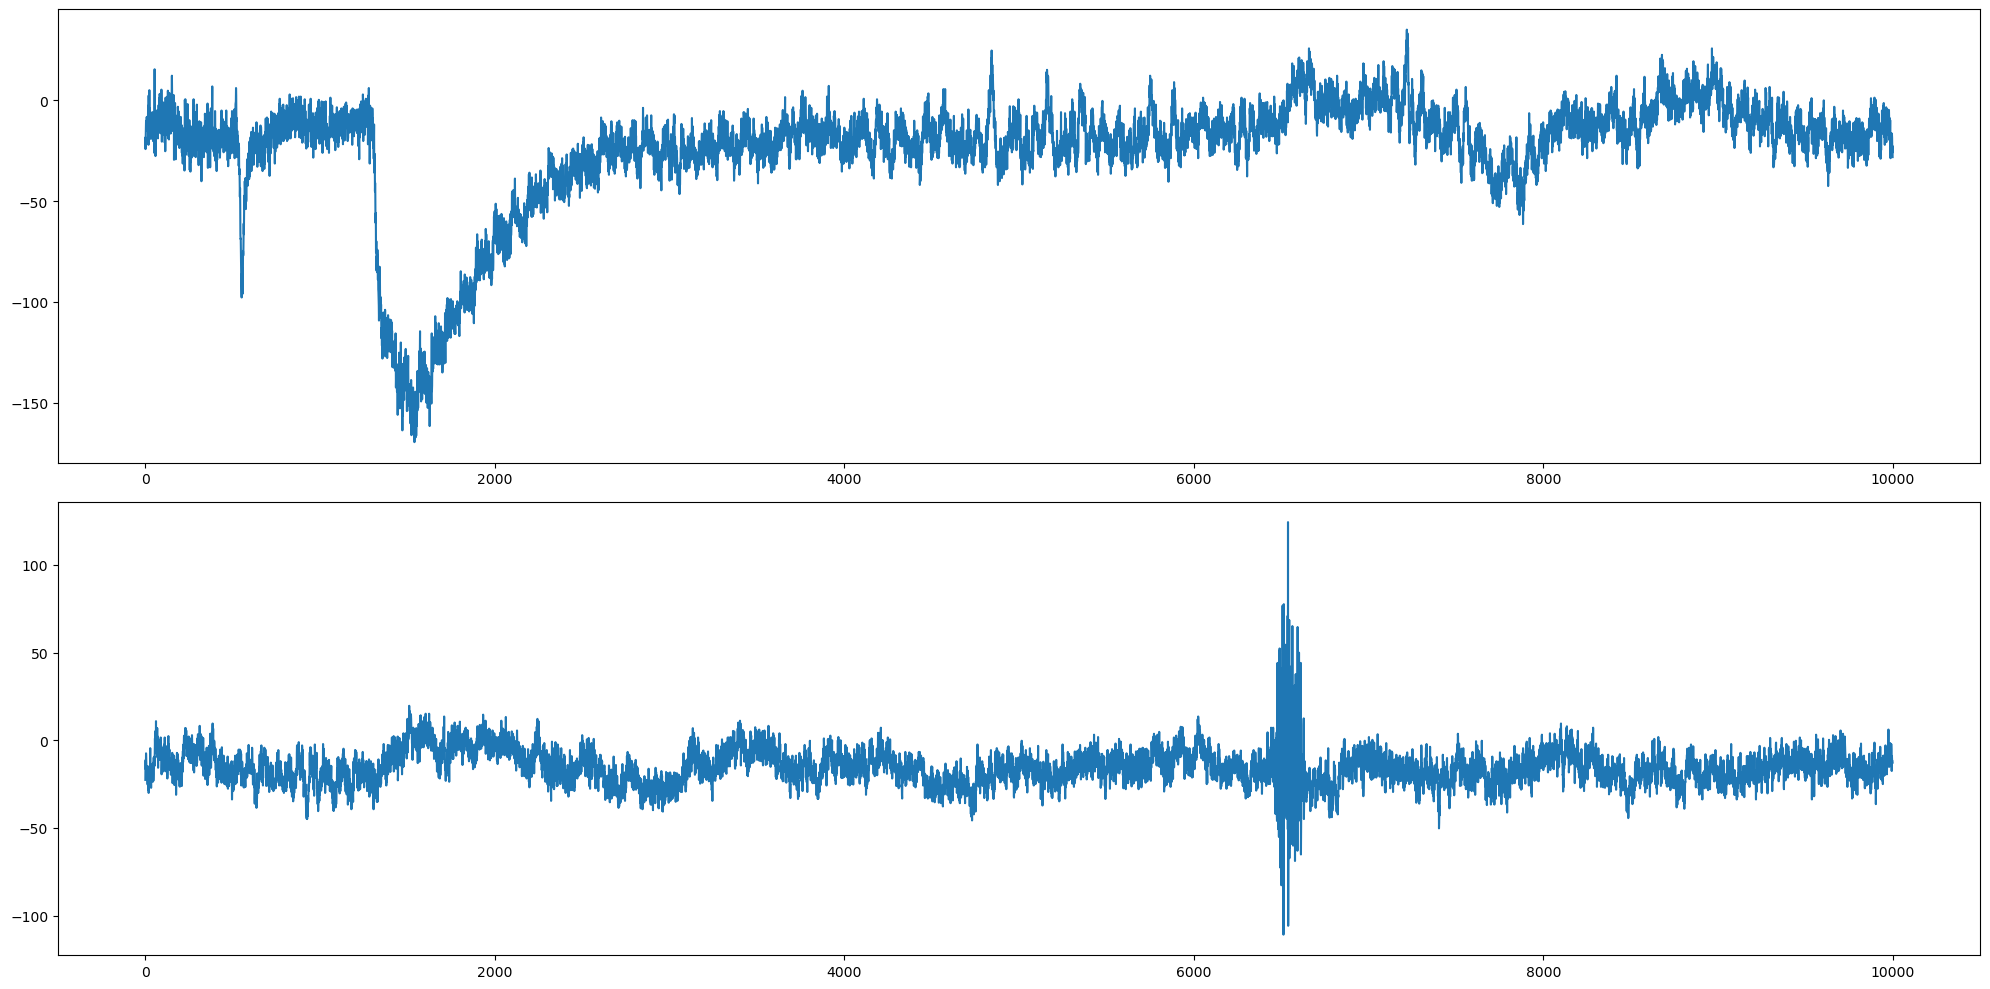

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].plot(x1)
axes[1].plot(x2)
fig.tight_layout()
plt.show()

In [23]:
df_agg[(df_agg['target_count']>1)&(df_agg['target_nunique']>1)]

,eeg_id,spectrogram_id,min,max,patient_id,target,target_count,target_nunique,averge_entropy,is_hard_ratio,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes
80,21379701,1841034439,2204.0,2362.0,32481,Other,18,3,5.890422,0.222222,0.132353,0.485294,0.000000,0.220588,0.000000,0.161765,68
83,21746311,1343094925,0.0,54.0,6489,Other,9,2,6.142714,0.000000,0.704082,0.000000,0.000000,0.000000,0.000000,0.295918,98
125,32067830,2060670605,9422.0,9502.0,55705,Other,5,2,7.464788,0.000000,0.000000,0.300000,0.000000,0.000000,0.000000,0.700000,10
140,36718960,1566496544,0.0,68.0,65378,GRDA,15,2,5.095723,0.666667,0.000000,0.000000,0.200000,0.000000,0.400000,0.400000,125
147,37347312,1611158521,342.0,370.0,45528,LPD,4,2,5.354353,0.750000,0.000000,0.352941,0.000000,0.000000,0.176471,0.470588,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17002,4268492759,233662031,638.0,674.0,25986,Seizure,2,2,6.958455,0.000000,0.250000,0.250000,0.000000,0.000000,0.000000,0.500000,4
17033,4279656286,319287046,488.0,562.0,26349,Seizure,19,2,7.456201,0.105263,0.035088,0.000000,0.000000,0.929825,0.000000,0.035088,57
17045,4282888597,1564580568,0.0,106.0,45464,LRDA,26,2,6.724017,0.000000,0.364486,0.000000,0.000000,0.635514,0.000000,0.000000,214
17048,4283246598,329782959,0.0,6.0,27986,GRDA,3,2,6.241086,0.333333,0.272727,0.136364,0.045455,0.000000,0.318182,0.227273,22


In [ ]:
(df_agg['is_hard_ratio'] > 0.4).sum()

In [ ]:
tmp = train_csv.groupby('eeg_id')['is_hard'].apply(lambda x: x.sum() / len(x)).sort_values(ascending=False)
tmp[tmp<0.3]

#.plot(kind='hist', bins=50, log=True)

In [ ]:
tmp = train_csv[train_csv['eeg_id']==3397233035 ]

averge_votes = tmp[targets].sum() / tmp['total_votes'].sum()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
tmp[tmp['is_hard'] == 1][targets_prob].T.plot(ax=ax, legend=False, color='red', ls='--')
tmp[tmp['is_hard'] == 0][targets_prob].T.plot(ax=ax, legend=False, color='blue', ls=":")
averge_votes.plot(ax=ax, color='black', lw=2)
ax.grid()
plt.show()

In [ ]:
tmp[targets].sum() / tmp['total_votes'].sum()

In [ ]:
train_csv[train_csv['is_hard'] == 1]['total_votes'].plot(kind='hist', bins=10, log=True)

In [ ]:
# plot in log scale
train_csv.groupby('eeg_id').size().plot(kind='hist', bins=50, log=True, title='Number of samples per eeg_id')

In [ ]:
train_csv.groupby('eeg_id')['total_votes'].mean().plot(kind='hist', bins=20, log=True, title='Mean total votes per eeg_id')